# Abraia - Getting started with image classification

In [2]:
%%capture
!python -m pip install abraia
!python -m pip install wget

import os
if not os.getenv('ABRAIA_KEY'):
    #@markdown <a href="https://abraia.me/console/settings" target="_blank">Get your ABRAIA_KEY</a>
    abraia_key = ''  #@param {type: "string"}
    %env ABRAIA_KEY=$abraia_key

from abraia import Abraia
 
abraia = Abraia()

# Cats and Dogs transfer learning

## Data preparation

Download the cats and dogs dataset and split some data for testing and validation.

In [3]:
import wget
import zipfile

from glob import glob
from sklearn.model_selection import train_test_split

def load_dataset(dataset='cats-and-dogs'):
    if not os.path.exists('datasets'):
        os.mkdir('datasets')
    if dataset == 'cats-and-dogs':
        zip_url = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip'
        zip_file = 'datasets/kagglecatsanddogs_3367a.zip'
        if not os.path.exists('datasets/kagglecatsanddogs_3367a.zip'):
            wget.download(zip_url, zip_file)
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall('datasets/')
        class_names = ['Cat', 'Dogs']
        return class_names

load_dataset()
!mv datasets/PetImages/* train/

cats_train, cats_test = train_test_split(glob('train/Cat/*.jpg'), test_size=0.30)
dogs_train, dogs_test = train_test_split(glob('train/Dog/*.jpg'), test_size=0.30)

TRAIN_DIR = 'train'
TEST_DIR = 'test'

!mkdir test

!mkdir test/Cat
files = ' '.join(cats_test)
!mv -t test/Cat $files

!mkdir test/Dog
files = ' '.join(dogs_test)
!mv -t test/Dog $files

mv: cannot move 'datasets/PetImages/Cat' to 'train/Cat': Directory not empty
mv: cannot move 'datasets/PetImages/Dog' to 'train/Dog': Directory not empty
mkdir: cannot create directory ‘test’: File exists
mkdir: cannot create directory ‘test/Cat’: File exists
mkdir: cannot create directory ‘test/Dog’: File exists


Plot some random images from the dataset.

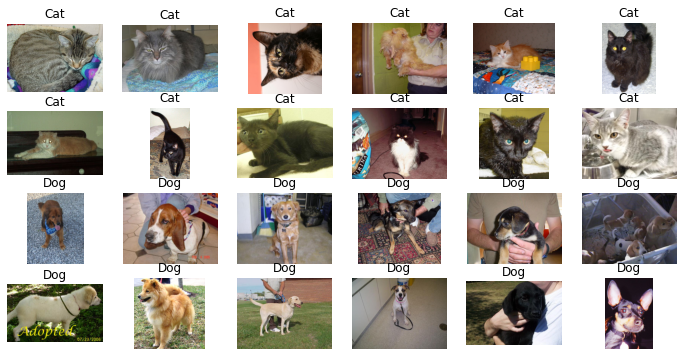

In [8]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

cats = np.random.choice(cats_train, 12)
dogs = np.random.choice(dogs_train, 12)
data = np.concatenate((cats, dogs))
labels = 12 * ['Cat'] + 12 *['Dog']

N, R, C = 25, 4, 6
plt.figure(figsize=(12, 6))
for k, (src, label) in enumerate(zip(data, labels)):
    im = Image.open(src).convert('RGB')
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(np.asarray(im))
    plt.axis('off')

## Data augmentation

In [5]:
from keras.preprocessing.image import ImageDataGenerator

target_size = (299, 299)
BATCH_SIZE = 32

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=target_size, batch_size=BATCH_SIZE, class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR, target_size=target_size, batch_size=BATCH_SIZE, class_mode='categorical')

Found 31000 images belonging to 3 classes.
Found 18998 images belonging to 2 classes.


Plot some images result of data augmentation.

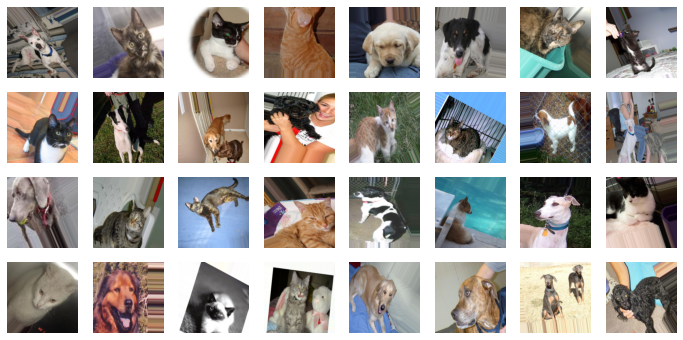

In [7]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 6))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

## Model customization

In [1]:
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3, preprocess_input

def create_model(CLASSES=2):
    base_model = InceptionV3(weights='imagenet', include_top=False)
    x = GlobalAveragePooling2D(name='avg_pool')(base_model.output)
    x = Dropout(0.4)(x)
    predictions = Dense(CLASSES, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # transfer learning
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(
        optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()

2021-08-24 10:38:28.235215: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-24 10:38:28.235264: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-08-24 10:38:32.087527: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-24 10:38:32.087596: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-24 10:38:32.087634: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jorge-ThinkPad-L13-Gen-2): /proc/driver/nvidia/version does not exist
2021-08-24 10:38:32.088388: I tensorflow/core/platfo

KeyboardInterrupt: 

## Transfer learning

In [ ]:
def train_model(model, train_generator, validation_generator, EPOCHS=5, BATCH_SIZE=32, STEPS_PER_EPOCH=320, VALIDATION_STEPS=64, MODEL_FILE='filename.model'):
    history = model.fit(
        train_generator, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,
        validation_data=validation_generator, validation_steps=VALIDATION_STEPS)
    model.save(MODEL_FILE)
    return history

def plot_train_history(history):
    plt.ylim(0, 1.01)
    plt.grid()
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Training loss','Test accuracy'], loc='upper right')

Epoch 1/5
320/320 [==============================] - 379s 1s/step - loss: 0.2321 - acc: 0.9048 - val_loss: 0.0770 - val_acc: 0.9722
Epoch 2/5
320/320 [==============================] - 368s 1s/step - loss: 0.1523 - acc: 0.9390 - val_loss: 0.0765 - val_acc: 0.9717
Epoch 3/5
320/320 [==============================] - 366s 1s/step - loss: 0.1449 - acc: 0.9452 - val_loss: 0.1000 - val_acc: 0.9653
Epoch 4/5
320/320 [==============================] - 366s 1s/step - loss: 0.1569 - acc: 0.9407 - val_loss: 0.1039 - val_acc: 0.9648
Epoch 5/5
320/320 [==============================] - 369s 1s/step - loss: 0.1400 - acc: 0.9453 - val_loss: 0.1694 - val_acc: 0.9429


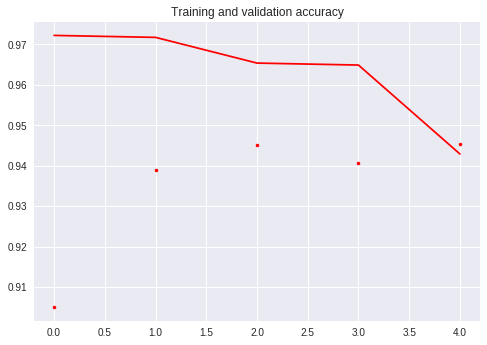

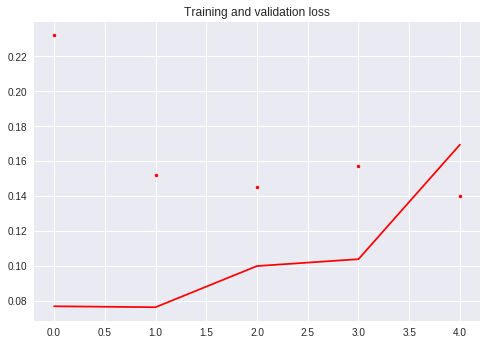

In [ ]:
MODEL_FILE = 'filename.model'
history = train_model(model, train_generator, validation_generator, MODEL_FILE=MODEL_FILE)
plot_train_history(history)

## Prediction of the custom model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
from keras.models import load_model


def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("cat", "dog")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()

In [ ]:
model = load_model(MODEL_FILE)

array([0.00105988, 0.99894017], dtype=float32)

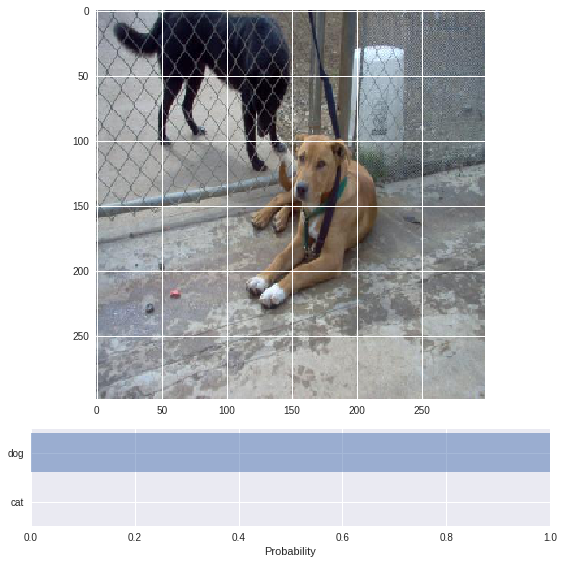

In [ ]:
img = image.load_img('test/Dog/110.jpg', target_size=target_size)
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds